In [21]:
import pickle
import pandas as pd
import numpy as np
import itertools
import os
import matplotlib.pyplot as plt
import glob as glob
sys.path.append('/home/marcush/projects/neural_control/')
sys.path.append('/home/marcush/projects/neural_control/analysis_scripts/')
sys.path.append('/home/marcush/projects/github_repos')
from loaders import load_tsao
from utils import calc_loadings
from collections import defaultdict
from scipy.stats import spearmanr
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import scipy.ndimage
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

### Load consolidated dimreduc dataframe

In [2]:
dimreduc_glom_path = '/home/marcush/Data/TsaoLabData/neural_control_output/dimreduc_deg_final_analysis_230322_214006_Jamie/dimreduc_deg_final_analysis_230322_214006_Jamie_glom.pickle'
with open(dimreduc_glom_path, 'rb') as f:
    dat = pickle.load(f) 

df_dimreduc = pd.DataFrame(dat)

### Load CCA model

In [9]:
ccamodel_dir = df_dimreduc['results_file'][0]
CCA_dims = 21 #None

if CCA_dims == None:
    ccamodel_path = glob.glob(ccamodel_dir+"/CCA_*.pickle")[0]
else:
    ccamodel_path = os.path.dirname(ccamodel_dir)+f"/CCA_{CCA_dims}_dims.pickle"

with open(ccamodel_path, 'rb') as file:
    ccamodel = pickle.load(file)

### Some useful values

In [10]:
dimensions = np.unique(df_dimreduc['dim'])
n_folds = np.unique(df_dimreduc['fold_idx'])
regions = np.unique(df_dimreduc['loader_args'].apply(lambda x: x.get('region')))
dimreduc_methods = np.unique(df_dimreduc['dimreduc_method'])

In [11]:
def recursive_defaultdict():
    return defaultdict(recursive_defaultdict)
importance_scores = recursive_defaultdict()



for reg in regions:
    if reg == 'ML':
        cca_proj = ccamodel.x_rotations_
    else:
        cca_proj = ccamodel.y_rotations_

    for dim in dimensions:

        importance_scores[reg]['CCA'][dim] = calc_loadings(cca_proj[:, 0:dim])
        
        for method in dimreduc_methods:    
            all_scores = np.zeros((len(n_folds), cca_proj.shape[0]))

            for n_fold in n_folds:

                coef = df_dimreduc[(df_dimreduc['loader_args'].apply(lambda x: x.get('region')) == reg)  & 
                                            (df_dimreduc['dim'] == dim) & (df_dimreduc['fold_idx'] == n_fold) &
                                            (df_dimreduc['dimreduc_method'] == method)]['coef'].iloc[0]
                
                all_scores[n_fold, :] = calc_loadings(coef)

            importance_scores[reg][method][dim] = np.mean(all_scores, 0)



## Visualizing unit importance across subspaces

In [12]:
ML_FFC_sum = np.sum(importance_scores['ML']['PCA'][np.max(dimensions)])
ML_FBC_sum = np.sum(importance_scores['ML']['LQGCA'][np.max(dimensions)])
ML_CCA_sum = np.sum(importance_scores['ML']['CCA'][np.max(dimensions)])

AM_FFC_sum = np.sum(importance_scores['AM']['PCA'][np.max(dimensions)])
AM_FBC_sum = np.sum(importance_scores['AM']['LQGCA'][np.max(dimensions)])
AM_CCA_sum = np.sum(importance_scores['AM']['CCA'][np.max(dimensions)])


print(f"ML FFC total importance: {ML_FFC_sum}")
print(f"ML FBC total importance: {ML_FBC_sum}")
print(f"ML CCA total importance: {ML_CCA_sum}")
print()
print(f"AM FFC total importance: {AM_FFC_sum}")
print(f"AM FBC total importance: {AM_FBC_sum}")
print(f"AM CCA total importance: {AM_CCA_sum}")



ML FFC total importance: 60.275494890372485
ML FBC total importance: 74.04078104658714
ML CCA total importance: 25.528540415084066

AM FFC total importance: 61.56742220109904
AM FBC total importance: 61.0496396812295
AM CCA total importance: 30.687921998648047


In [13]:
def recursive_defaultdict():
    return defaultdict(recursive_defaultdict)
subspace_importance_correlations = recursive_defaultdict()
subspace_importance_pvals = recursive_defaultdict()

proj_methods = np.append(dimreduc_methods, 'CCA')

for region in regions:
    region_method_pairs = set()  # Set to keep track of seen combinations
    if region == 'AM':
        DIM = 21 #39
    elif region == 'ML':
        DIM = 21

    for method0, method1 in itertools.product(proj_methods, proj_methods):
        sorted_0 = tuple(sorted([region, method0]))
        sorted_1 = tuple(sorted([region, method1]))
        
        combo = (tuple(sorted((sorted_0, sorted_1))))
        
        if combo in region_method_pairs:
            continue  
        elif method0 == method1:
            continue
        region_method_pairs.add(combo)



        scores0 = importance_scores[region][method0][DIM]
        scores1 = importance_scores[region][method1][DIM]

        corrs, pvals = spearmanr(scores0, scores1 ) 

        subspace_importance_correlations[region][f"{method0}_{method1}"] = corrs
        subspace_importance_pvals[region][f"{method0}_{method1}"] = pvals


In [14]:
AM_corrs = np.array(list(subspace_importance_correlations['AM'].values()))
ML_corrs = np.array(list(subspace_importance_correlations['ML'].values()))
comparisons = np.array(list(subspace_importance_correlations['AM'].keys()))

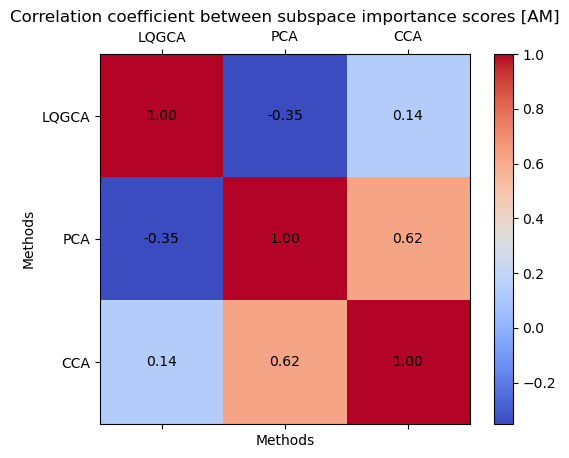

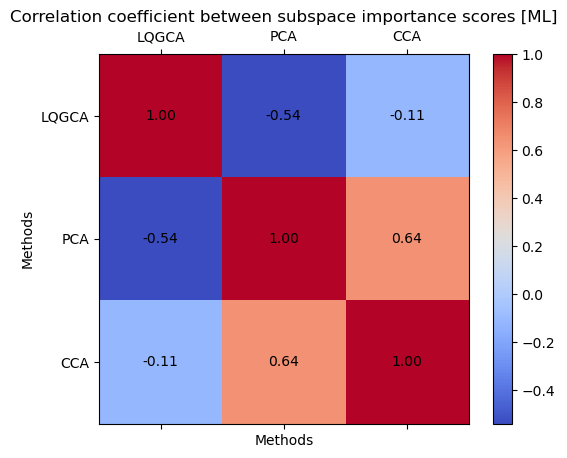

In [15]:
methods = proj_methods
indices = {name: i for i, name in enumerate(proj_methods)}

# Function to create a heatmap from correlations
def create_heatmap(corrs, comparisons, methods, region):
    # Initialize a 3x3 matrix of NaNs
    matrix = np.full((3, 3), np.nan)
    
    # Fill the matrix with correlations
    for comp, corr in zip(comparisons, corrs):
        m1, m2 = comp.split('_')
        i, j = indices[m1], indices[m2]
        matrix[i, j] = corr
        matrix[j, i] = corr  # Mirror the value
    
    # Diagonal (comparison of the method with itself)
    for i in range(3):
        matrix[i, i] = 1.0  # Perfect correlation with itself
    
    # Plotting
    fig, ax = plt.subplots()
    cax = ax.matshow(matrix, cmap='coolwarm')
    plt.colorbar(cax)
    ax.set_xticks(range(len(methods)))
    ax.set_yticks(range(len(methods)))
    ax.set_xticklabels(methods)
    ax.set_yticklabels(methods)

    for (i, j), val in np.ndenumerate(matrix):
        ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='black')

    plt.title(f'Correlation coefficient between subspace importance scores [{region}]')
    plt.xlabel('Methods')
    plt.ylabel('Methods')
    plt.show()

create_heatmap(AM_corrs, comparisons, proj_methods, 'AM')
create_heatmap(ML_corrs, comparisons, proj_methods, 'ML')


# Figs from paper

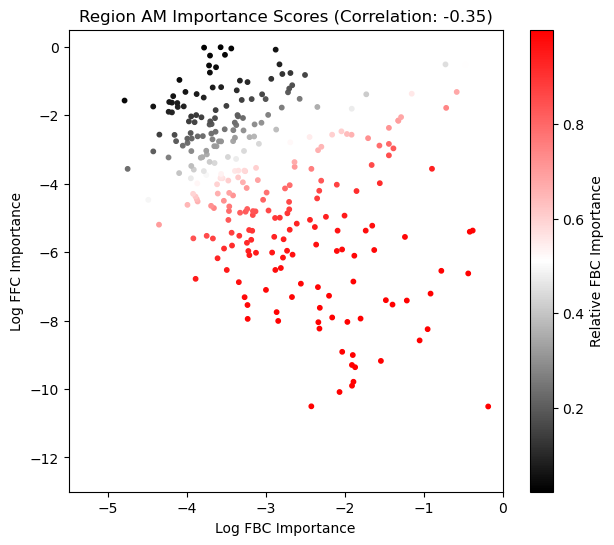

In [16]:
region = 'AM'
DIM = 21  


FFC_scores = importance_scores[region]['PCA'][DIM]
FBC_scores = importance_scores[region]['LQGCA'][DIM]

rel_FBC_import = FBC_scores / (FBC_scores + FFC_scores)

sort_inds = np.argsort(FFC_scores)

FBC_scores_plt = np.log(FBC_scores[sort_inds[2:]])
FFC_scores_plt = np.log(FFC_scores[sort_inds[2:]])
rel_FBC_import_plt = rel_FBC_import[sort_inds[2:]]

cmap = mcolors.LinearSegmentedColormap.from_list('black_white_red', ['black', 'white', 'red'])

plt.figure(figsize=(7, 6))
scatter = plt.scatter(FBC_scores_plt, FFC_scores_plt, c=rel_FBC_import_plt, cmap=cmap, marker='o', s=10)
colorbar = plt.colorbar(scatter)
colorbar.set_label('Relative FBC Importance')

plt.title(f'Region {region} Importance Scores (Correlation: {np.corrcoef(FBC_scores_plt, FFC_scores_plt)[0, 1]:.2f})')
plt.xlabel('Log FBC Importance')
plt.ylabel('Log FFC Importance')
plt.xlim(-5.5, 0)
plt.ylim(-13, 0.5)
plt.show()

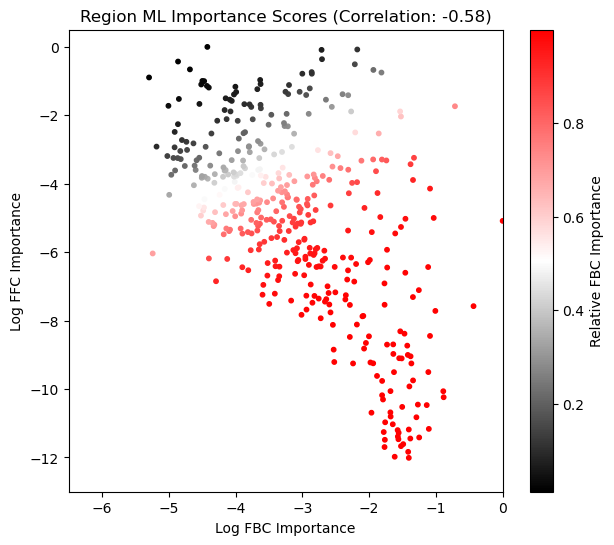

In [17]:
region = 'ML'
DIM = 21  


FFC_scores = importance_scores[region]['PCA'][DIM]
FBC_scores = importance_scores[region]['LQGCA'][DIM]

rel_FBC_import = FBC_scores / (FBC_scores + FFC_scores)

sort_inds = np.argsort(FFC_scores)

FBC_scores_plt = np.log(FBC_scores[sort_inds[2:]])
FFC_scores_plt = np.log(FFC_scores[sort_inds[2:]])
rel_FBC_import_plt = rel_FBC_import[sort_inds[2:]]

cmap = mcolors.LinearSegmentedColormap.from_list('black_white_red', ['black', 'white', 'red'])

plt.figure(figsize=(7, 6))
scatter = plt.scatter(FBC_scores_plt, FFC_scores_plt, c=rel_FBC_import_plt, cmap=cmap, marker='o', s=10)
colorbar = plt.colorbar(scatter)
colorbar.set_label('Relative FBC Importance')

plt.title(f'Region {region} Importance Scores (Correlation: {np.corrcoef(FBC_scores_plt, FFC_scores_plt)[0, 1]:.2f})')
plt.xlabel('Log FBC Importance')
plt.ylabel('Log FFC Importance')
plt.xlim(-6.5, 0)
plt.ylim(-13, 0.5)
plt.show()

# Look at waveforms by importance scores

Preloading data...
Preloading data...


In [18]:
def make_hashable(obj):
    if isinstance(obj, dict):
        return tuple(sorted((key, make_hashable(value)) for key, value in obj.items()))
    elif isinstance(obj, (list, tuple)):
        return tuple(make_hashable(item) for item in obj)
    else:
        return obj


unique_hashes = set(make_hashable(d) for d in df_dimreduc['full_arg_tuple'])
unique_dicts = [dict(u) for u in unique_hashes]
preload_dict_path = df_dimreduc['data_path'][0] + "/preloaded/preloadDict.pickle"

with open(preload_dict_path, 'rb') as file:
    preloadDict = pickle.load(file)

In [20]:
for arg_dict in unique_dicts:
    arg_tuple = tuple(sorted(arg_dict.items()))


    for args in preloadDict.keys():

        if args == arg_tuple:

            preloadID = preloadDict[arg_tuple]
            loaded_data_path = os.path.dirname(preload_dict_path) + f"/preloaded_data_{preloadID}.pickle"
            
            if arg_dict['region'] == 'AM':
                with open(loaded_data_path, 'rb') as file:
                    AM_loaded_data = pickle.load(file)

            elif arg_dict['region'] == 'ML':
                with open(loaded_data_path, 'rb') as file:
                    ML_loaded_data = pickle.load(file)

AM_spikes = np.sum(AM_loaded_data['spike_rates'], 1)
ML_spikes = np.sum(ML_loaded_data['spike_rates'], 1)

NameError: name 'AM_loaded_data' is not defined

### Rebuild the spike rate structure

In [26]:
decoding_glom_path = '/home/marcush/Data/TsaoLabData/neural_control_output_new/decoding_deg_230322_214006_Jamie/decoding_deg_230322_214006_Jamie_glom.pickle'
with open(decoding_glom_path, 'rb') as f:
    dat_decode = pickle.load(f) 

df_decode = pd.DataFrame(dat_decode)

all_loader_args = np.unique(df_decode['full_arg_tuple'])

region = 'AM' 
regIdx = [ ('region', region) in args for args in all_loader_args]
loader_args = dict(all_loader_args[regIdx][0])
AM_loaded_data = load_tsao(**loader_args)


region = 'ML' 
regIdx = [ ('region', region) in args for args in all_loader_args]
loader_args = dict(all_loader_args[regIdx][0])
ML_loaded_data = load_tsao(**loader_args)


AM_spikes = np.sum(AM_loaded_data['spike_rates'], 1)
ML_spikes = np.sum(ML_loaded_data['spike_rates'], 1)

Preloading data...
Preloading data...


In [14]:
StimulusOFFDurations = AM_loaded_data['StimulusOFFDurations']
StimulusOnDurations = AM_loaded_data['StimulusOnDurations']
TrialDurations = StimulusOFFDurations + StimulusOnDurations

AM_numUnits = AM_loaded_data['NumUnits']
numTrials = AM_loaded_data['NumTrials']
SpikeMats_AM = AM_loaded_data['spike_times']
ML_numUnits = ML_loaded_data['NumUnits']
SpikeMats_ML = ML_loaded_data['spike_times']

bin_width = AM_loaded_data['bin_width']

###################### Params

bin_size = 15
median_stim_on_time = 510
window = median_stim_on_time+120  # the time after which we'll look for baseline responses


AM_baseline_means = np.zeros(AM_numUnits)
AM_baseline_stds = np.zeros(AM_numUnits)

for unit in np.arange(AM_numUnits):
    unit_baseline_responses = []

    for trial in np.arange(numTrials):

        # Get baseline response rates if there's a sufficiently long baseline response.
        if TrialDurations[trial] > window: 
            sp_times_base = SpikeMats_AM[trial, unit][0]
            sp_times_base = sp_times_base[sp_times_base > window] - window # isolate baseline response

            base_raster = np.zeros( int(TrialDurations[trial]) - window )
            base_raster[sp_times_base] = 1

            base_inds = np.arange(0, len(base_raster), bin_size)
            binned_sums_baseline = np.add.reduceat(base_raster, base_inds)
            unit_baseline_responses = np.hstack((unit_baseline_responses,  binned_sums_baseline))
    
    AM_baseline_means[unit] = np.mean(unit_baseline_responses)
    AM_baseline_stds[unit] = np.std(unit_baseline_responses)






Text(0.5, 1.0, 'Trial Durations')

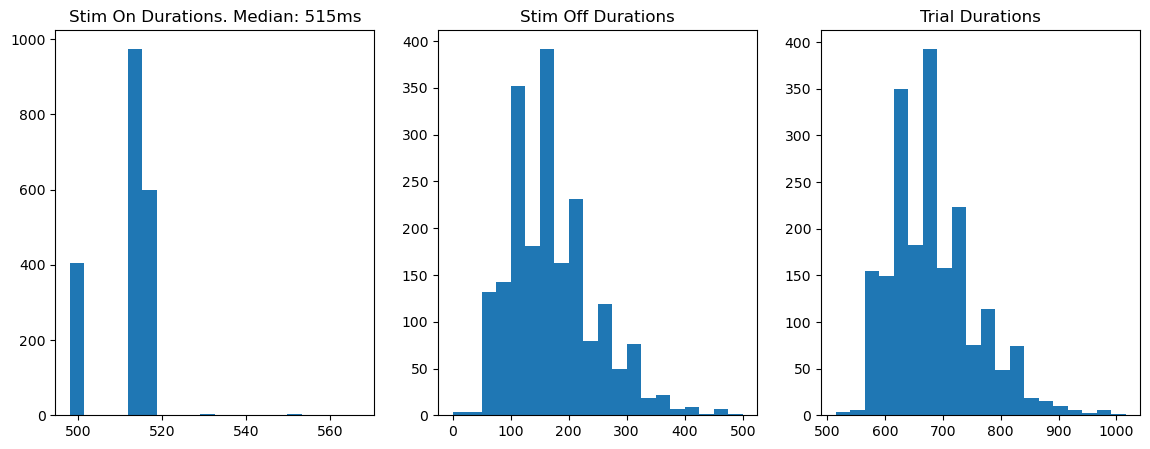

In [15]:
plt.figure(figsize=(14, 5))

plt.subplot(1,3,1)
median_stim_on_time = int(np.median(StimulusOnDurations))
plt.hist(StimulusOnDurations, 20)
plt.title(f"Stim On Durations. Median: {median_stim_on_time}ms")


plt.subplot(1,3,2)
plt.hist(StimulusOFFDurations, 20)
plt.title("Stim Off Durations")

plt.subplot(1,3,3)
plt.hist(TrialDurations, 20)
plt.title("Trial Durations")

In [5]:
AM_numUnits = AM_loaded_data['NumUnits']
numTrials = AM_loaded_data['NumTrials']
SpikeMats_AM = AM_loaded_data['spike_times']
ML_numUnits = ML_loaded_data['NumUnits']
SpikeMats_ML = ML_loaded_data['spike_times']

bin_width = AM_loaded_data['bin_width']
num_bins = np.shape(AM_loaded_data['spike_rates'])[1]
trial_dur = num_bins * bin_width
num_trials = AM_loaded_data['NumTrials']

NameError: name 'AM_loaded_data' is not defined

In [33]:
spike_rates = ML_loaded_data['spike_rates']
bin_width = AM_loaded_data['bin_width']
StimulusOFFDurations = AM_loaded_data['StimulusOFFDurations']
StimulusOnDurations = AM_loaded_data['StimulusOnDurations']
TrialDurations = StimulusOFFDurations + StimulusOnDurations
median_stim_on_time = 510
window = median_stim_on_time + 120 

threshold_bin = window // bin_width # take responses after the cutoff/stimulation period

baseline_responses = []

for unit in range(spike_rates.shape[2]): 
    unit_baseline = []  
    
    for trial in range(spike_rates.shape[0]):
              
        if TrialDurations[trial] > window: # only take baseline responses if the trials were actually long enough

            trial_spike_rate = spike_rates[trial, :, unit]
            unit_baseline.append(trial_spike_rate[threshold_bin:])

    baseline_responses.append(unit_baseline)



In [39]:
spike_rates = ML_loaded_data['spike_rates']
bin_width = AM_loaded_data['bin_width']

# Take responses after this much trial time
median_stim_on_time = 510
window = median_stim_on_time + 120 
threshold_bin = window // bin_width  

baseline_responses = []
for unit in range(spike_rates.shape[2]): 
    unit_baseline = []  
    
    for trial in range(spike_rates.shape[0]):
        trial_spike_rate = spike_rates[trial, :, unit]
              
        if len(trial_spike_rate) > threshold_bin:  # Only consider trials that are long enough
            unit_baseline.append(trial_spike_rate[threshold_bin:])
    
    baseline_responses.append(np.concatenate(unit_baseline))

baseline_responses = np.vstack(baseline_responses)
base_means = np.mean(baseline_responses, axis=1)
base_stds = np.std(baseline_responses, axis=1)


zscored_rates = (spike_rates - base_means) / base_stds



(1991, 19, 413) (413,) (413,) (1991, 19, 413)


In [47]:
t = 4
u = 12
spike_rates[t, :, u]

array([-2., -2.,  0., -2., -2., -2., -2.,  0., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2.])

In [6]:
###################### Params

AM_numUnits = AM_loaded_data['NumUnits']
numTrials = AM_loaded_data['NumTrials']
SpikeMats_AM = AM_loaded_data['spike_times']
ML_numUnits = ML_loaded_data['NumUnits']
SpikeMats_ML = ML_loaded_data['spike_times']

bin_width = AM_loaded_data['bin_width']
num_bins = np.shape(AM_loaded_data['spike_rates'])[1]
trial_dur = num_bins * bin_width
num_trials = AM_loaded_data['NumTrials']
bin_size = 15
median_stim_on_time = 510
window = median_stim_on_time+120  # the time after which we'll look for baseline responses
num_bins = trial_dur // bin_size + (trial_dur % bin_size != 0)
bin_inds = np.arange(0, trial_dur, bin_size)


spike_rates = ML_loaded_data['spike_rates']

numBaselineTrials = np.sum(TrialDurations > window)

baseline_responses = []


for unit in np.arange(AM_numUnits):
    unit_baseline_responses = []

    for trial in np.arange(numTrials):

        # Get baseline response rates
        if TrialDurations[trial] > window: 
            sp_times_base = SpikeMats_AM[trial, unit][0]
            sp_times_base = sp_times_base[sp_times_base > window] - window # isolate baseline response

            base_raster = np.zeros( int(TrialDurations[trial]) - window )
            base_raster[sp_times_base] = 1

            base_inds = np.arange(0, len(base_raster), bin_size)
            binned_sums_baseline = np.add.reduceat(base_raster, base_inds)
            unit_baseline_responses = np.hstack((unit_baseline_responses,  binned_sums_baseline))
    
    AM_baseline_means[unit] = np.mean(unit_baseline_responses)
    AM_baseline_stds[unit] = np.std(unit_baseline_responses)





NameError: name 'trial_dur' is not defined

### Bin Responses

TypeError: only size-1 arrays can be converted to Python scalars

In [17]:
###################### Params
bin_size = 15
median_stim_on_time = 510
window = median_stim_on_time+120  # the time after which we'll look for baseline responses


print(f"Number of trials used to estimate baseline: {np.sum(TrialDurations > window)}")
num_bins = trial_dur // bin_size + (trial_dur % bin_size != 0)
bin_inds = np.arange(0, trial_dur, bin_size)

###################### Region AM
AM_binned_rates = np.zeros((numTrials, num_bins, AM_numUnits))
AM_baseline_means = np.zeros(AM_numUnits)
AM_baseline_stds = np.zeros(AM_numUnits)

for unit in np.arange(AM_numUnits):
    unit_baseline_responses = []

    for trial in np.arange(numTrials):

        # Get stimulus response rates
        sp_times = SpikeMats_ML[trial, unit][0]
        sp_times = sp_times[sp_times < trial_dur] 
        trial_raster = np.zeros(trial_dur)
        trial_raster[sp_times] = 1

        AM_binned_rates[trial, :, unit] = (np.add.reduceat(trial_raster, bin_inds) / bin_size) * 1000 # spikes/s


        # Get baseline response rates
        if TrialDurations[trial] > window: 
            sp_times_base = SpikeMats_ML[trial, unit][0]
            sp_times_base = sp_times_base[sp_times_base > window] - window # isolate baseline response

            base_raster = np.zeros( int(TrialDurations[trial]) - window )
            base_raster[sp_times_base] = 1

            base_inds = np.arange(0, len(base_raster), bin_size)
            binned_sums_baseline = np.add.reduceat(base_raster, base_inds)
            unit_baseline_responses = np.hstack((unit_baseline_responses,  binned_sums_baseline))
    
    AM_baseline_means[unit] = np.mean(unit_baseline_responses)
    AM_baseline_stds[unit] = np.std(unit_baseline_responses)


###################### Region ML
ML_binned_rates = np.zeros((numTrials, num_bins, ML_numUnits))
ML_baseline_means = np.zeros(ML_numUnits)
ML_baseline_stds = np.zeros(ML_numUnits)

for unit in np.arange(ML_numUnits):
    unit_baseline_responses = []

    for trial in np.arange(numTrials):

        # Get stimulus response rates
        sp_times = SpikeMats_ML[trial, unit][0]
        sp_times = sp_times[sp_times < trial_dur] 
        trial_raster = np.zeros(trial_dur)
        trial_raster[sp_times] = 1

        ML_binned_rates[trial, :, unit] = (np.add.reduceat(trial_raster, bin_inds) / bin_size) * 1000 # spikes/s


        # Get baseline response rates
        if TrialDurations[trial] > window: 
            sp_times_base = SpikeMats_ML[trial, unit][0]
            sp_times_base = sp_times_base[sp_times_base > window] - window # isolate baseline response

            base_raster = np.zeros( int(TrialDurations[trial]) - window )
            base_raster[sp_times_base] = 1

            base_inds = np.arange(0, len(base_raster), bin_size)
            binned_sums_baseline = np.add.reduceat(base_raster, base_inds)
            unit_baseline_responses = np.hstack((unit_baseline_responses,  binned_sums_baseline))
    
    ML_baseline_means[unit] = np.mean(unit_baseline_responses)
    ML_baseline_stds[unit] = np.std(unit_baseline_responses)


Number of trials used to estimate baseline: 1327


### Smooth Responses

In [18]:
smooth_kernel_size = 3

AM_binned_rates_smoothed = scipy.ndimage.gaussian_filter1d(AM_binned_rates, sigma = smooth_kernel_size, axis=1)
ML_binned_rates_smoothed = scipy.ndimage.gaussian_filter1d(ML_binned_rates, sigma = smooth_kernel_size, axis=1)


### Z-score the binned, smoothed rates (use baseline activity to determine means+stds)

In [19]:
z_AM_binned_rates_smoothed = (AM_binned_rates_smoothed - AM_baseline_means) / AM_baseline_stds
z_ML_binned_rates_smoothed = (ML_binned_rates_smoothed - ML_baseline_means) / ML_baseline_stds

### Average the binned, smoothed, and z-scored activity 

In [20]:
AM_binned_rates_smoothed_avg = np.mean(AM_binned_rates_smoothed, 0).T
ML_binned_rates_smoothed_avg = np.mean(ML_binned_rates_smoothed, 0).T

z_AM_binned_rates_smoothed_avg = np.mean(z_AM_binned_rates_smoothed, 0).T
z_ML_binned_rates_smoothed_avg = np.mean(z_ML_binned_rates_smoothed, 0).T

Text(0.5, 1.0, 'All Avg Firing Rates in ML (Z-scored)')

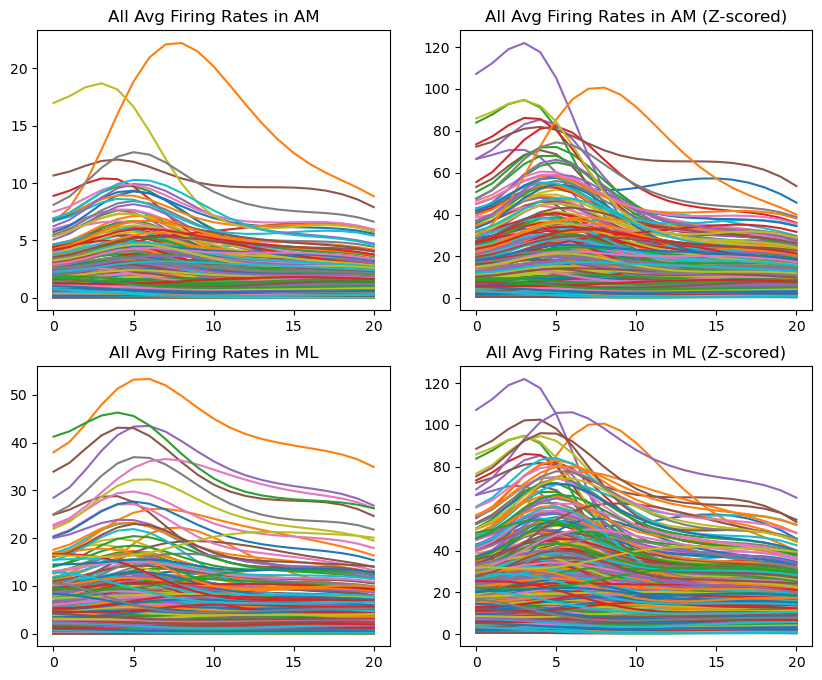

In [21]:
plot_window = [0, int(510/bin_size)+1]


to_plot_0 = np.mean(ML_binned_rates_smoothed, 0)
to_plot_1 = np.mean(z_ML_binned_rates_smoothed, 0)

plt.figure(figsize=(10, 8))

plt.subplot(2,2,1)
plt.plot(AM_binned_rates_smoothed_avg[:, plot_window[0]:plot_window[-1]].T);
plt.title("All Avg Firing Rates in AM")


plt.subplot(2,2,2)
plt.plot(z_AM_binned_rates_smoothed_avg[:, plot_window[0]:plot_window[-1]].T);
plt.title("All Avg Firing Rates in AM (Z-scored)")


plt.subplot(2,2,3)
plt.plot(ML_binned_rates_smoothed_avg[:, plot_window[0]:plot_window[-1]].T);
plt.title("All Avg Firing Rates in ML")


plt.subplot(2,2,4)
plt.plot(z_ML_binned_rates_smoothed_avg[:, plot_window[0]:plot_window[-1]].T);
plt.title("All Avg Firing Rates in ML (Z-scored)")




## Firing Rate profiles by importance

In [51]:
thresh = 0.5

ffc_scores_am = importance_scores['AM']['PCA'][DIM]
fbc_scores_am = importance_scores['AM']['LQGCA'][DIM]
rel_FBC_import_am = fbc_scores_am / (fbc_scores_am + ffc_scores_am)

ffc_scores_ml = importance_scores['ML']['PCA'][DIM]
fbc_scores_ml = importance_scores['ML']['LQGCA'][DIM]
rel_FBC_import_ml = fbc_scores_ml / (fbc_scores_ml + ffc_scores_ml)

frac_FBC_AM = np.sum(rel_FBC_import_am > thresh) / len(rel_FBC_import_am)
frac_FBC_ML = np.sum(rel_FBC_import_ml > thresh) / len(rel_FBC_import_ml)

print(f"Fraction of neurons with > 0.5 rel FBC in AM: {frac_FBC_AM}")
print(f"Fraction of neurons with > 0.5 rel FBC in ML: {frac_FBC_ML}")

Fraction of neurons with > 0.5 rel FBC in AM: 0.5888888888888889
Fraction of neurons with > 0.5 rel FBC in ML: 0.6949152542372882


In [18]:
print(f"AM: {(0.588+0.696)/2}")
print(f"ML: {(0.695+0.564)/2}")

395/(395+116+125)

AM: 0.6419999999999999
ML: 0.6295


0.6210691823899371

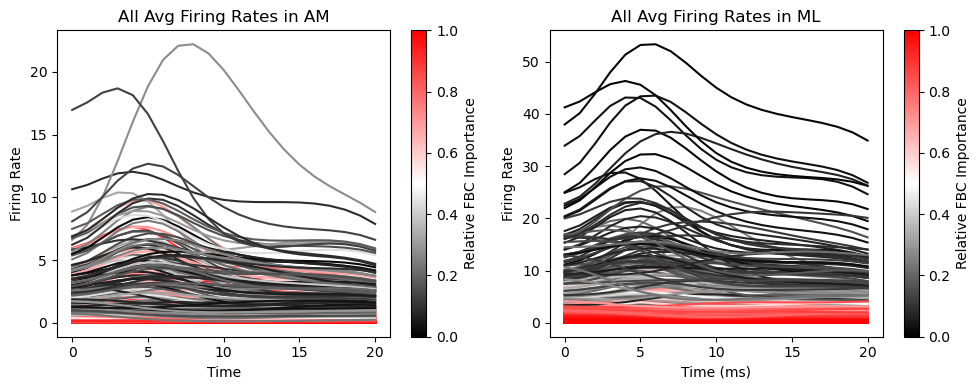

In [22]:
ffc_scores_am = importance_scores['AM']['PCA'][DIM]
fbc_scores_am = importance_scores['AM']['LQGCA'][DIM]
rel_FBC_import_am = fbc_scores_am / (fbc_scores_am + ffc_scores_am)

ffc_scores_ml = importance_scores['ML']['PCA'][DIM]
fbc_scores_ml = importance_scores['ML']['LQGCA'][DIM]
rel_FBC_import_ml = fbc_scores_ml / (fbc_scores_ml + ffc_scores_ml)

cut_time_plot = int(510/bin_size)+1

# Create a colormap
cmap = mcolors.LinearSegmentedColormap.from_list('black_white_red', ['black', 'white', 'red'])

# Create the subplot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot for AM region
for i in range(AM_binned_rates_smoothed_avg.shape[0]):
    axes[0].plot(AM_binned_rates_smoothed_avg[i, 0:cut_time_plot], color=cmap(rel_FBC_import_am[i]))
axes[0].set_title("All Avg Firing Rates in AM")
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Firing Rate')

# Plot for ML region
for i in range(ML_binned_rates_smoothed_avg.shape[0]):
    axes[1].plot(ML_binned_rates_smoothed_avg[i, 0:cut_time_plot], color=cmap(rel_FBC_import_ml[i]))
axes[1].set_title("All Avg Firing Rates in ML")
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Firing Rate')

# Add colorbars
sm_am = ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
sm_am.set_array([])
cbar_am = fig.colorbar(sm_am, ax=axes[0], orientation='vertical')
cbar_am.set_label('Relative FBC Importance')

sm_ml = ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
sm_ml.set_array([])
cbar_ml = fig.colorbar(sm_ml, ax=axes[1], orientation='vertical')
cbar_ml.set_label('Relative FBC Importance')

plt.tight_layout()
plt.show()


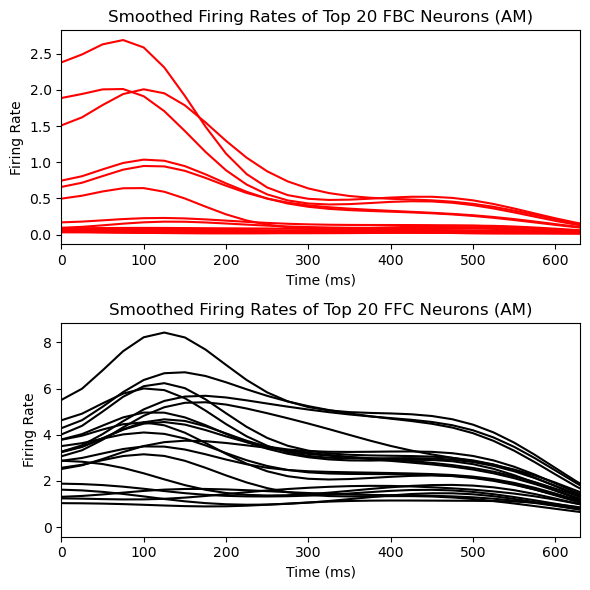

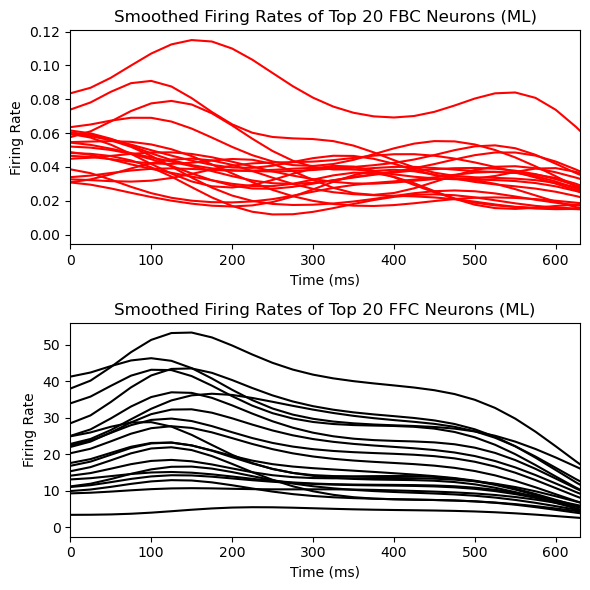

In [50]:
num_units_plot = 20
cut_time_plot = 510+120

##################### Region AM
ffc_scores_am = importance_scores['AM']['PCA'][DIM]
fbc_scores_am = importance_scores['AM']['LQGCA'][DIM]
rel_FBC_import_am = fbc_scores_am / (fbc_scores_am + ffc_scores_am)
rel_FFC_import_am = ffc_scores_am / (fbc_scores_am + ffc_scores_am)


# Top 10 relative FBC neurons
top_fbc_inds = np.argsort(rel_FBC_import_am)[-num_units_plot:]
AM_FBC_neurons = AM_binned_rates_smoothed_avg[top_fbc_inds, :]

# Bottom 10 relative FBC neurons
top_ffc_inds = np.argsort(rel_FFC_import_am)[-num_units_plot:]
AM_FFC_neurons = AM_binned_rates_smoothed_avg[top_ffc_inds, :]


plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.title(f'Smoothed Firing Rates of Top {num_units_plot} FBC Neurons (AM)')
for i in range(AM_FBC_neurons.shape[0]):
    plt.plot(bin_inds, AM_FBC_neurons[i], color='r') #, label=f'Neuron {top_neurons_inds[i]}')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate')
plt.xlim([0, cut_time_plot])
#plt.legend()

# Plot for 10 neurons with least rel_FBC importance
plt.subplot(2, 1, 2)
plt.title(f'Smoothed Firing Rates of Top {num_units_plot} FFC Neurons (AM)')
for i in range(AM_FFC_neurons.shape[0]):
    plt.plot(bin_inds, AM_FFC_neurons[i], color='k') #, label=f'Neuron {least_neurons_inds[i]}')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate')
#plt.legend()
plt.xlim([0, cut_time_plot])
plt.tight_layout()
plt.show()



##################### Region ML
ffc_scores_ml = importance_scores['ML']['PCA'][DIM]
fbc_scores_ml = importance_scores['ML']['LQGCA'][DIM]
rel_FBC_import_ml = fbc_scores_ml / (fbc_scores_ml + ffc_scores_ml)
rel_FFC_import_ml = ffc_scores_ml / (fbc_scores_ml + ffc_scores_ml)


# Top 10 relative FBC neurons
top_fbc_inds = np.argsort(rel_FBC_import_ml)[-num_units_plot:]
ML_FBC_neurons = ML_binned_rates_smoothed_avg[top_fbc_inds, :]

# Bottom 10 relative FBC neurons
top_ffc_inds = np.argsort(rel_FFC_import_ml)[-num_units_plot:]
ML_FFC_neurons = ML_binned_rates_smoothed_avg[top_ffc_inds, :]



plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.title(f'Smoothed Firing Rates of Top {num_units_plot} FBC Neurons (ML)')
for i in range(ML_FBC_neurons.shape[0]):
    plt.plot(bin_inds, ML_FBC_neurons[i], color='r') #, label=f'Neuron {top_neurons_inds[i]}')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate')
plt.xlim([0, cut_time_plot])
#plt.legend()

# Plot for 10 neurons with least rel_FBC importance
plt.subplot(2, 1, 2)
plt.title(f'Smoothed Firing Rates of Top {num_units_plot} FFC Neurons (ML)')
for i in range(ML_FFC_neurons.shape[0]):
    plt.plot(bin_inds, ML_FFC_neurons[i], color='k') #, label=f'Neuron {least_neurons_inds[i]}')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate')
plt.xlim([0, cut_time_plot])
#plt.legend()

plt.tight_layout()
plt.show()


### Plotting function of probe depth

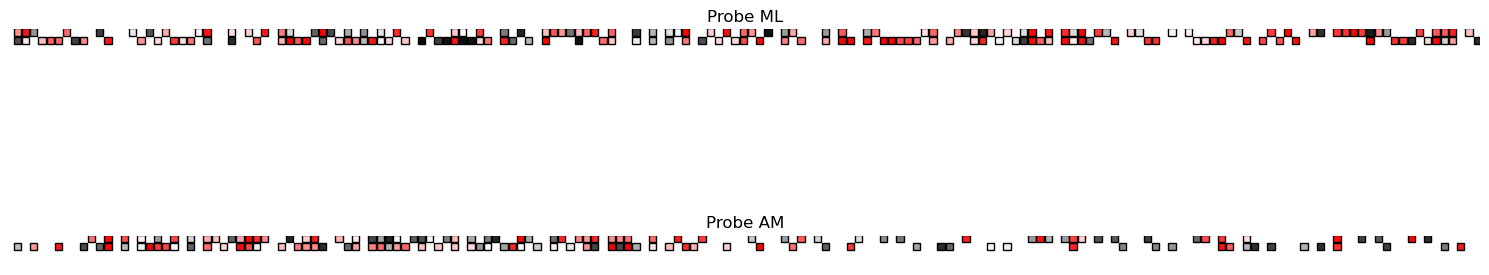

In [97]:
# Create mapping of channels to importance scores for each region
region_ml = 'ML'
region_am = 'AM'
DIM = 21

AM_channel_ids = np.array(AM_loaded_data['channelID'], dtype=int)
ML_channel_ids = np.array(ML_loaded_data['channelID'], dtype=int)


# Rel FBC
ffc_scores_ml = importance_scores[region_ml]['PCA'][DIM]
fbc_scores_ml = importance_scores[region_ml]['LQGCA'][DIM]
ffc_scores_am = importance_scores[region_am]['PCA'][DIM]
fbc_scores_am = importance_scores[region_am]['LQGCA'][DIM]

rel_FBC_import_ml = fbc_scores_ml / (fbc_scores_ml + ffc_scores_ml)
rel_FBC_import_am = fbc_scores_am / (fbc_scores_am + ffc_scores_am)

# Create a custom colormap from black to white to red
cmap = mcolors.LinearSegmentedColormap.from_list('black_white_red', ['black', 'white', 'red'])

# Function to plot the probe with average color importance
def plot_probe_with_avg_color(ax, probe_channel_ids, rel_FBC_import, title):
    num_channels = 374
    contact_width = 40
    contact_height = 40
    contact_spacing = 5

    # Compute average rel_FBC_import for each contact
    avg_rel_FBC_import = np.array([
        np.mean(rel_FBC_import[probe_channel_ids == i]) if np.any(probe_channel_ids == i) else None
        for i in range(num_channels)
    ])

    # Plot the probe contacts
    for i in range(num_channels):
        if avg_rel_FBC_import[i] is None:
            continue  # Skip if no units on the contact

        # Calculate the position of each contact
        row = (i % 2) * (contact_height + contact_spacing)
        column = (i // 2) * (contact_width + contact_spacing)

        # Determine the facecolor
        facecolor = cmap(avg_rel_FBC_import[i])

        # Plot the contact
        rect = plt.Rectangle((column, row), contact_width, contact_height, edgecolor='black', facecolor=facecolor)
        ax.add_patch(rect)

    # Set plot limits and labels
    ax.set_xlim(-20, 8000)
    ax.set_ylim(-80, 80)
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.axis('off')


# Plot the probes one above the other
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot for ML (Probe 0)
plot_probe_with_avg_color(axes[0], ML_channel_ids, rel_FBC_import_ml, 'Probe ML')

# Plot for AM (Probe 1)
plot_probe_with_avg_color(axes[1], AM_channel_ids, rel_FBC_import_am, 'Probe AM')

# Adjust the spacing between the subplots
plt.subplots_adjust(hspace=-0.75)

plt.tight_layout()
plt.show()


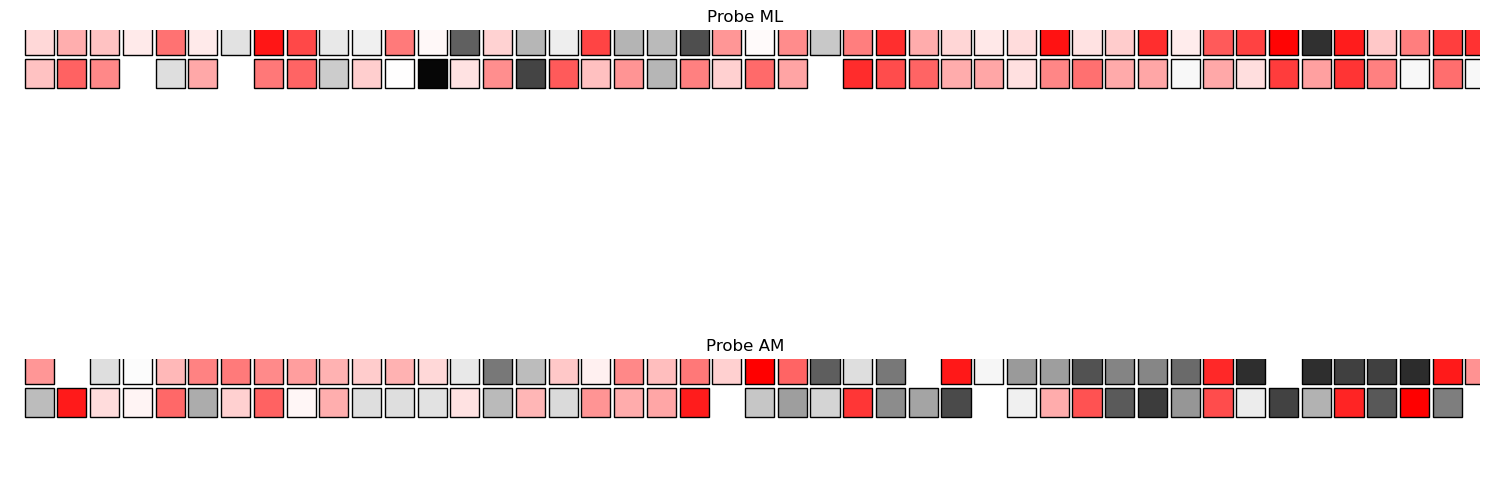

In [98]:
AM_channel_ids = np.array(AM_loaded_data['channelID'], dtype=int)
ML_channel_ids = np.array(ML_loaded_data['channelID'], dtype=int)

# Ensure data alignment by filtering importance_scores based on channel_ids
region_ml = 'ML'
region_am = 'AM'
DIM = 21

# Create mapping of channels to importance scores for each region
ffc_scores_ml = importance_scores[region_ml]['PCA'][DIM]
fbc_scores_ml = importance_scores[region_ml]['LQGCA'][DIM]
ffc_scores_am = importance_scores[region_am]['PCA'][DIM]
fbc_scores_am = importance_scores[region_am]['LQGCA'][DIM]

# Compute relative FBC importance for each region
rel_FBC_import_ml = fbc_scores_ml / (fbc_scores_ml + ffc_scores_ml)
rel_FBC_import_am = fbc_scores_am / (fbc_scores_am + ffc_scores_am)

# Create a custom colormap from black to white to red
cmap = mcolors.LinearSegmentedColormap.from_list('black_white_red', ['black', 'white', 'red'])

# Function to plot the probe with averaged color importance over groups of 4 channels
def plot_probe_with_avg_color(ax, probe_channel_ids, rel_FBC_import, title):
    num_channels = 374
    contact_width = 40
    contact_height = 40
    contact_spacing = 5

    # Compute average rel_FBC_import for each group of 4 channels
    avg_rel_FBC_import = []
    for i in range(0, num_channels, 4):
        channels_in_group = [probe_channel_ids == j for j in range(i, i + 4)]
        valid_channels = np.any(channels_in_group, axis=0)
        avg_rel_FBC_import.append(np.mean(rel_FBC_import[valid_channels]) if np.any(valid_channels) else None)
    
    # Plot the averaged contacts
    for i in range(len(avg_rel_FBC_import)):
        if avg_rel_FBC_import[i] is None:
            continue  # Skip if no units in the group

        # Calculate the position of each averaged contact
        row = (i % 2) * (contact_height + contact_spacing)
        column = (i // 2) * (contact_width + contact_spacing)

        # Determine the facecolor
        facecolor = cmap(avg_rel_FBC_import[i])

        # Plot the averaged contact
        rect = plt.Rectangle((column, row), contact_width, contact_height, edgecolor='black', facecolor=facecolor)
        ax.add_patch(rect)

    # Set plot limits and labels
    ax.set_xlim(-20, 8000 // 4)
    ax.set_ylim(-80, 80)
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.axis('off')


# Plot the probes one above the other
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot for ML (Probe 0)
plot_probe_with_avg_color(axes[0], ML_channel_ids, rel_FBC_import_ml, 'Probe ML')

# Plot for AM (Probe 1)
plot_probe_with_avg_color(axes[1], AM_channel_ids, rel_FBC_import_am, 'Probe AM')

plt.subplots_adjust(hspace=-0.25)
plt.tight_layout()
plt.show()


## Plotting waveforms

In [99]:
top_n_units = 20

ffc_scores_ml = importance_scores['ML']['PCA'][DIM]
fbc_scores_ml = importance_scores['ML']['LQGCA'][DIM]
ML_waveforms = ML_loaded_data['waveforms'][ML_loaded_data['probeID'] == 0]

rel_fbc = fbc_scores_am / (fbc_scores_am + ffc_scores_am)
rel_ffc = ffc_scores_am / (fbc_scores_am + ffc_scores_am)

sort_vals_fbc = rel_fbc #fbc_scores_ml #
sort_vals_ffc = rel_ffc #ffc_scores_ml #

# Top 10 neurons by FBC importance
top_neurons_inds_fbc = np.argsort(sort_vals_fbc)[-top_n_units:][::-1]
top_waveforms_fbc = ML_waveforms[top_neurons_inds_fbc, :]
top_waveforms_fbc = top_waveforms_fbc - np.mean(top_waveforms_fbc, axis=1, keepdims=True)

# Top 10 neurons by FFC importance
top_neurons_inds_ffc = np.argsort(sort_vals_ffc)[-top_n_units:][::-1]
top_waveforms_ffc = ML_waveforms[top_neurons_inds_ffc, :]
top_waveforms_ffc = top_waveforms_ffc - np.mean(top_waveforms_ffc, axis=1, keepdims=True)

# Create the subplot
plt.figure(figsize=(20, 10))

# Plot for top 10 neurons by FBC importance
plt.subplot(1, 2, 1)
plt.title(f'Waveforms of Top {top_n_units} FBC Neurons (ML)')
for i in range(top_waveforms_fbc.shape[0]):
    plt.plot(top_waveforms_fbc[i], color='red') #, label=f'Neuron {top_neurons_inds_fbc[i]}')
plt.xlabel('Time')
plt.ylabel('Waveform Amplitude')
#plt.legend()

# Plot for top 10 neurons by FFC importance
plt.subplot(1, 2, 2)
plt.title(f'Waveforms of Top {top_n_units} FFC Neurons (ML)')
for i in range(top_waveforms_ffc.shape[0]):
    plt.plot(top_waveforms_ffc[i], color='black') #, label=f'Neuron {top_neurons_inds_ffc[i]}')
plt.xlabel('Time')
plt.ylabel('Waveform Amplitude')
#plt.legend()

plt.tight_layout()
plt.show()


IndexError: boolean index did not match indexed array along dimension 0; dimension is 413 but corresponding boolean dimension is 941

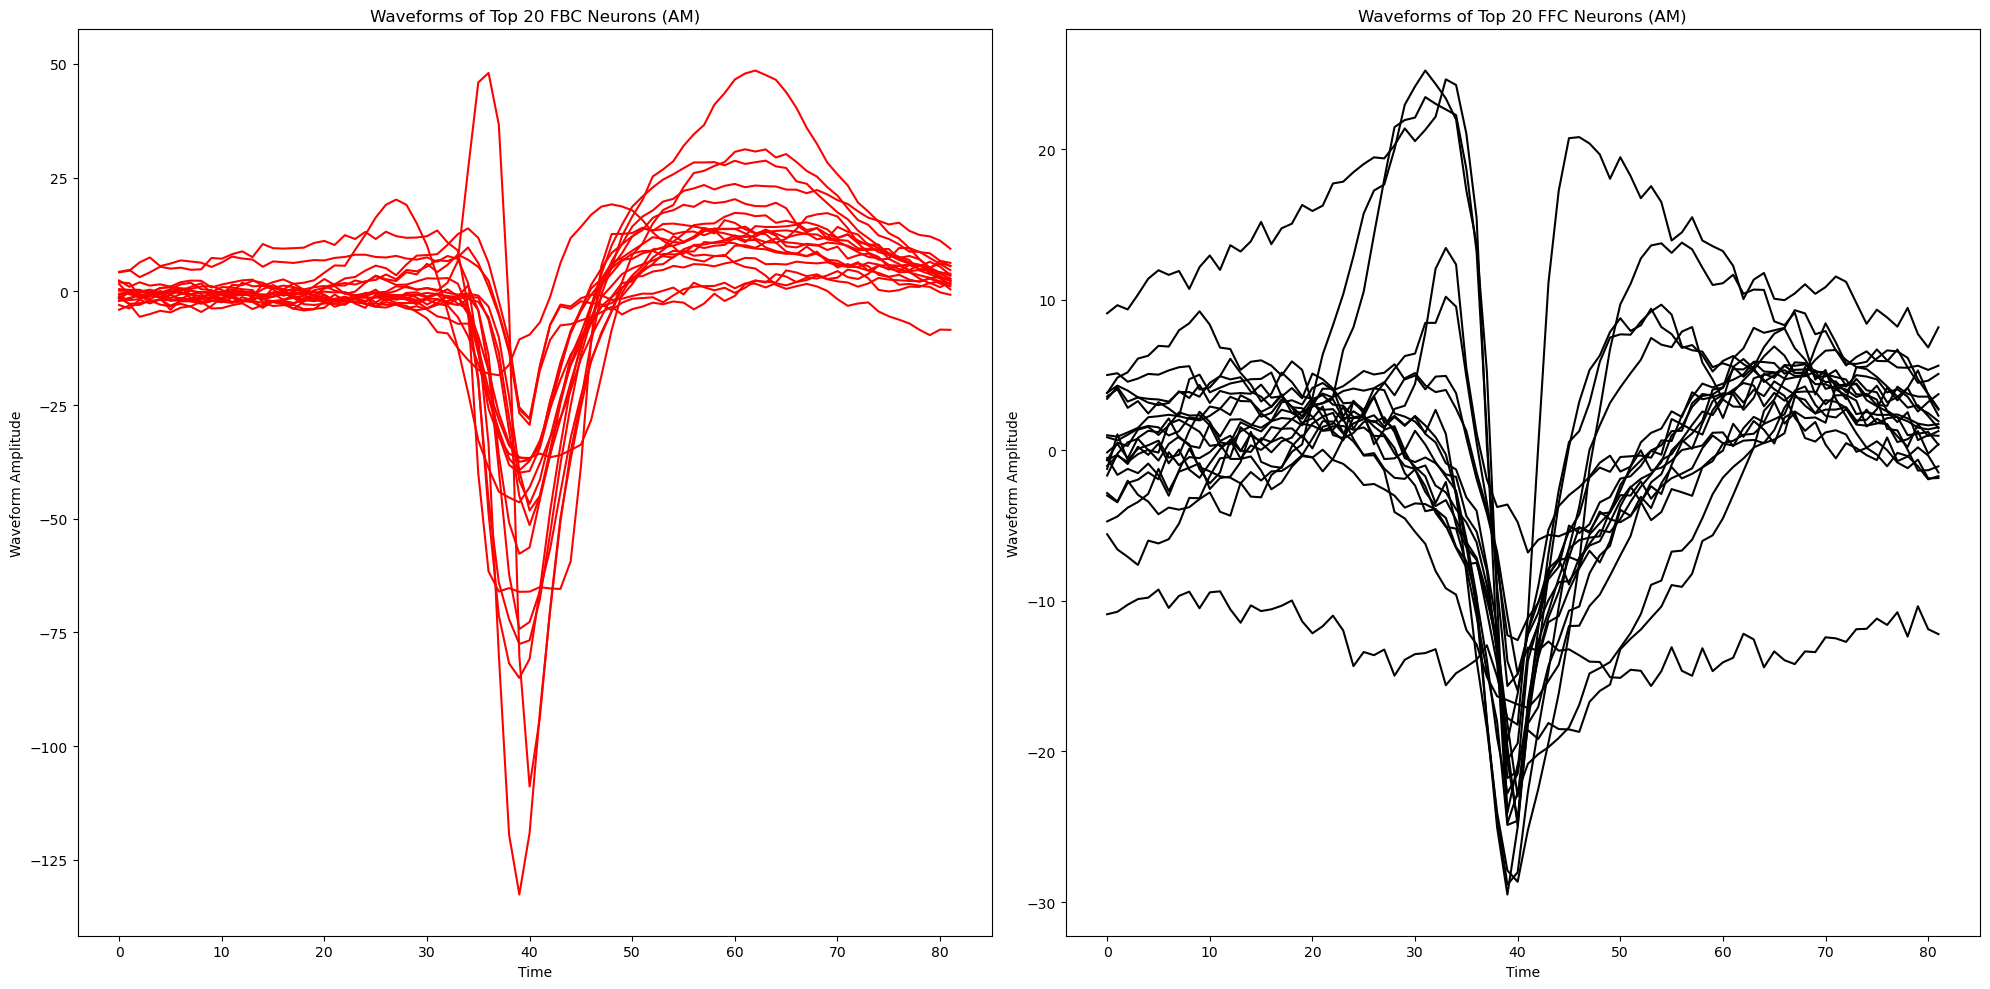

In [42]:
top_n_units = 20

ffc_scores_am = importance_scores['AM']['PCA'][DIM]
fbc_scores_am = importance_scores['AM']['LQGCA'][DIM]
AM_waveforms = AM_loaded_data['waveforms'][AM_loaded_data['probeID'] == 1]

rel_fbc = fbc_scores_am / (fbc_scores_am + ffc_scores_am)
rel_ffc = ffc_scores_am / (fbc_scores_am + ffc_scores_am)

sort_vals_fbc = rel_fbc #fbc_scores_am #
sort_vals_ffc = rel_ffc #ffc_scores_am #

# Top 10 neurons by FBC importance
top_neurons_inds_fbc = np.argsort(sort_vals_fbc)[-top_n_units:][::-1]
top_waveforms_fbc = AM_waveforms[top_neurons_inds_fbc, :]
top_waveforms_fbc = top_waveforms_fbc - np.mean(top_waveforms_fbc, axis=1, keepdims=True)

# Top 10 neurons by FFC importance
top_neurons_inds_ffc = np.argsort(sort_vals_ffc)[-top_n_units:][::-1]
top_waveforms_ffc = AM_waveforms[top_neurons_inds_ffc, :]
top_waveforms_ffc = top_waveforms_ffc - np.mean(top_waveforms_ffc, axis=1, keepdims=True)

# Create the subplot
plt.figure(figsize=(20, 10))

# Plot for top 10 neurons by FBC importance
plt.subplot(1, 2, 1)
plt.title(f'Waveforms of Top {top_n_units} FBC Neurons (AM)')
for i in range(top_waveforms_fbc.shape[0]):
    plt.plot(top_waveforms_fbc[i], color='red') #, label=f'Neuron {top_neurons_inds_fbc[i]}')
plt.xlabel('Time')
plt.ylabel('Waveform Amplitude')
#plt.legend()

# Plot for top 10 neurons by FFC importance
plt.subplot(1, 2, 2)
plt.title(f'Waveforms of Top {top_n_units} FFC Neurons (AM)')
for i in range(top_waveforms_ffc.shape[0]):
    plt.plot(top_waveforms_ffc[i], color='black') #, label=f'Neuron {top_neurons_inds_ffc[i]}')
plt.xlabel('Time')
plt.ylabel('Waveform Amplitude')
#plt.legend()

plt.tight_layout()
plt.show()
